# Physcis 160: Homework 10

Notebook for the last homework of the class!

In [15]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import numpy as np
# We import the tools to handle general Graphs
import networkx as nx
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

## Problem 1: QAOA using qiskit 

Part 1: 

Cell 1: Below ia a function defining the graph G of the problem. Run this cell. 
Cell 2: Below is the a function that calculates the cost of a given bitstrings.
Cell 3: Calculate the minimum value of the cost function, and to what bitstring the minimum corresponds to

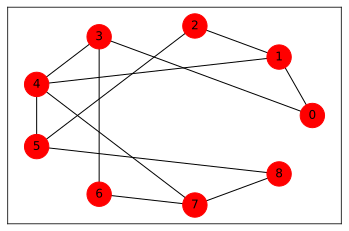

In [17]:
# Generating the butterfly graph of the 2d grid
n     = 9
V     = np.arange(0,n,1)
E     = [(0,1,-1.0), (1,2,2.0), (3,4,11.0), (4,5,-4.0), (6,7,-3.0), (7,8,3.0), (0,3,5.0), (1,4,-6), (2,5,4), (3,6,-3), (4,7,-7),(5,8,8)]

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.circular_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [18]:
# Compute the value of the cost function
def cost_function_C(x, G):
    '''
    Calculates and returns the value of the cost function for a particular state x
    Remember that a bitstring is of the form 010111001 (for example). By convention, 
    string 0 has a value z0=-1 and the string 1 has a value z1=1. 
    '''
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0
    
    # global field defined in the problem
    h = 2
    
    for index in G.nodes():
        #Term that adds the longitudinal term contribution if x[index]. 
        C = C + h*2*(int(x[index]) - 0.5)

    for index in E:
        #Term that adds the ZZ term if x[index[0]], and x[index[1]]. 
        e1 = index[0]
        e2 = index[1]
        J = G[e1][e2]['weight']
        C = C + J*(2*(int(x[e1]) - 0.5))*(2*(int(x[e2]) - 0.5))
        
    return C

In [127]:
#Generate all the possible bitstrings of length 9 and compute the minimum value of cost function: 
#To what bit-string does the minimum correspond?

#COMPLETE THE CODE...

#Hint: here is a code that computes all bit strings of length N: 
def generate_bitstrings(n): 
    l = []
    for i in range(2**n, 2**(n+1)):
        l.append('0'*(n-len(bin(i)[3:]))+bin(i)[3:])
    return l
bitstrings = generate_bitstrings(9)
arr = [cost_function_C(bitstring, G) for bitstring in bitstrings]
print(f"The minimum value is {np.min(arr)}, with bitstring '{bitstrings[np.argmin(arr)]}.'")

The minimum value is -57.0, with bitstring '001100001.'


Part 2.

Cell 1: A function named create_qaoa_circ that creates the qaoa circuit for parameters theta, and a depth of p layers. Complete the function by adding the initial leyer of Hadamard gates, the needed gates for $U(C,\gamma)$, the layer of the mixer unitary, and measurement registers for all qubits after $p$ layers

Cell 2: Run the function create_qaoa_circ for p=1 and print it out. Choose your favorite angles to start with 

In [67]:
def create_qaoa_circ(theta, p, verbose=False): 
    '''
    Creates & returns QAOA circuit with particular angles theta=[gammas, betas]
    '''
    gamma,beta=theta[0:p],theta[p:]

    # prepare the quantum and classical resisters
    QAOA = QuantumCircuit(n)
    
    # global field defined in the problem
    h = 2

    # apply the layer of Hadamard gates to all qubits
    #COMPLETE THIS CODE....
    for i in range(n):
        QAOA.h(i)
    
    #Max edge calculator. We want to normalize the weights when we define the unitary
    max_edge = 0
    count = 0
    
    for edge in E:
        count = count + 1
        if edge[2]**2 > max_edge:
            max_edge = edge[2]**2
            
    for i in range(p):
        # apply the Ising type gates with angle gamma along the edges in E
        for edge in E:
            k = edge[0]
            l = edge[1]
            w = edge[2]
            gamma_kl = gamma[i] * w / max_edge
            
            #Adding the needed terms for U(C, gamma). 
            #COMPLETE THIS CODE...
            # U(c, gamma) = Rz(h gamma / Jmax) CNOT Rz(gamma Jij / Jmax)
            QAOA.rzz(gamma_kl, k, l)
            # QAOA.cx(k, l); QAOA.rz(gamma_kl, k); QAOA.cx(k, l)
        
        gamma_h = gamma[i] * h / max_edge
        for k in range(n):
            QAOA.rz(gamma_h, k)

            
        # then apply the single qubit X - rotations with angle beta to all qubits
        QAOA.barrier()
        #COMPLETE THIS CODE
        for k in range(n):
            QAOA.rx(-beta[i], k)


        # Finally measure the result in the computational basis
        QAOA.barrier()
        
    #Add measurements
    #COMPLETE THIS CODE...
    QAOA.measure_all()

    if verbose:
        QAOA.draw(output='mpl')
    
    return QAOA

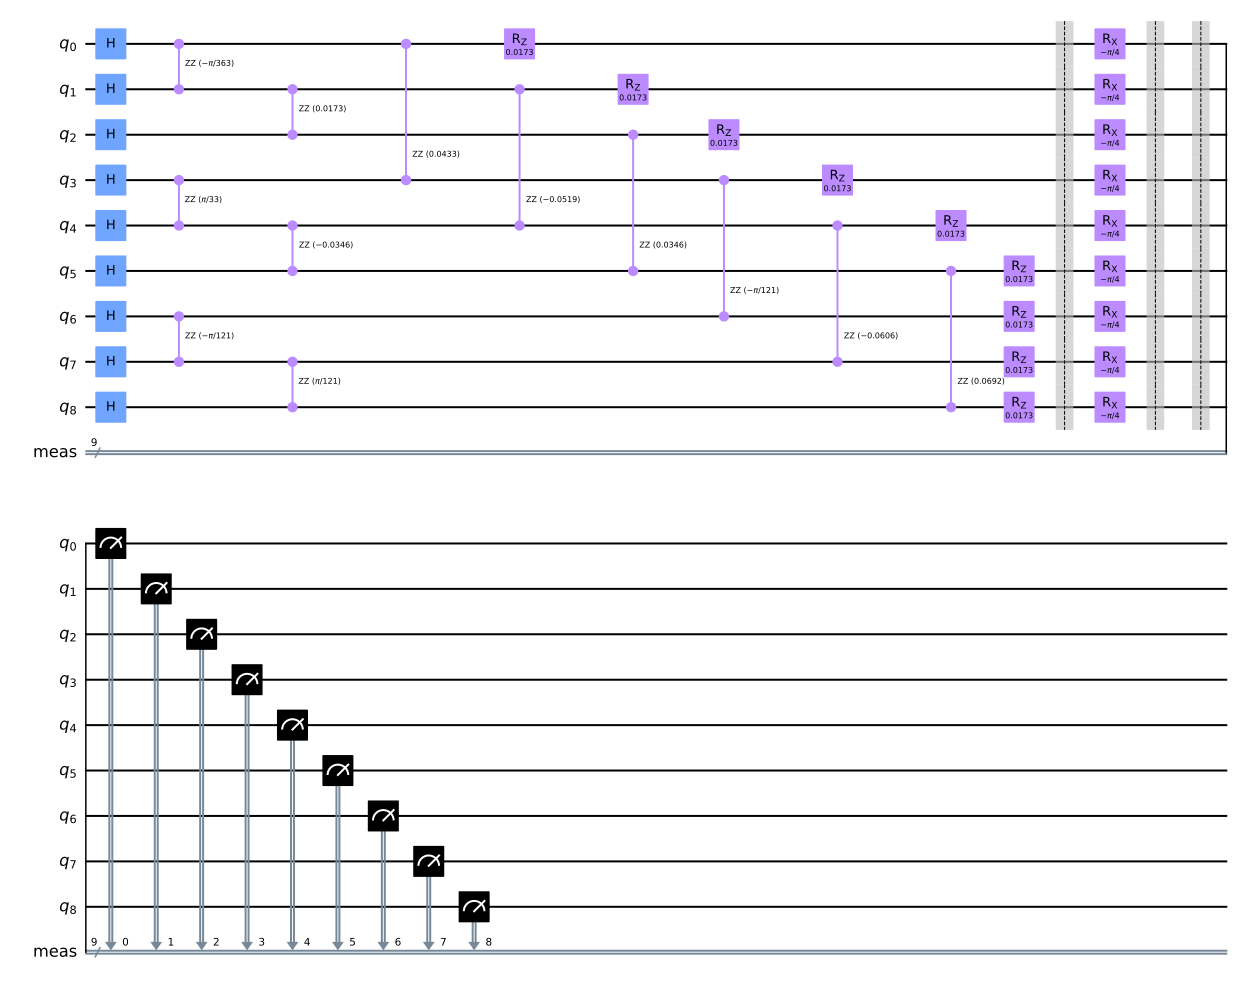

In [129]:
#Produce the QAOA circuit for p=1 and print it out.

#COMPLETE THIS CODE...
QAOA_circ = create_qaoa_circ([np.pi / 3, np.pi / 4, np.pi / 5], 1)
QAOA_circ.draw('mpl')

The cell below contains functions to compute the expectation values of results. Because these are direct copied of those found in https://qiskit.org/textbook/ch-applications/qaoa.html, you do not need to change them. Run the cell and move on. 

In [49]:
def compute_expectation(counts):
    """
    Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bitstring, val as count
        G: networkx graph
    Returns:
        avg: (float) expectation value
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():     
        obj = cost_function_C(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(p, shots=512):
    """Runs parametrized circuit
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        qc = create_qaoa_circ(theta, p)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=shots).result().get_counts()
        return compute_expectation(counts)
    
    return execute_circ

Part 3: Use the above functions to calculate the minimum of the cost function using the QAOA. You can take inspiration from https://qiskit.org/textbook/ch-applications/qaoa.html. You may need to change the value of $p$ and shots 

In [77]:
from scipy.optimize import minimize
#Minimize! COMPLETE CODE... 
p = 1
expectation = get_expectation(1, shots=1000)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
print(res)

     fun: -1.5625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([2.12500225, 0.49369642])


Part 4: Lastly, vizualize the results we got above. We take the resulting parameters theta for the QAOA circuit, and run a simulation for those. We plot a histogram of the value measured for the cost function. That is, build a dictionary called "dict" that contains the values of cost_function_C and the number of times those were measured by your simulation.

How does the average and distribution of the cost function values compare to the minimum you computed in part 1? 

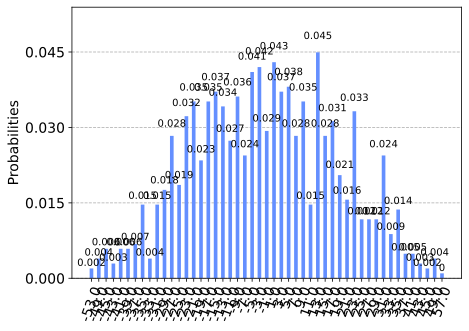

In [78]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

qc_res = create_qaoa_circ(res.x, p)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

dic = {}

for x in counts: 
    obj = cost_function_C(x, G)
    if obj not in dic.keys(): 
        dic[obj]=counts[x]
    else: dic[obj]+=counts[x]

plot_histogram(dic)

<font color="blue" size="4">
    Let us try different values of p and shots.
</font>

     fun: -4.2734375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 210
  status: 1
 success: True
       x: array([ 8.03945103, 10.18771182,  8.99966517,  6.99966497,  6.00033657,
        2.24487012,  5.77558548,  2.77511003,  8.13558475,  2.13605838,
        2.73108381,  4.73108381,  5.7161469 ,  3.7161469 ,  4.72781705,
        0.73265037,  8.78216051,  1.98562767,  5.73539315,  2.18789595])


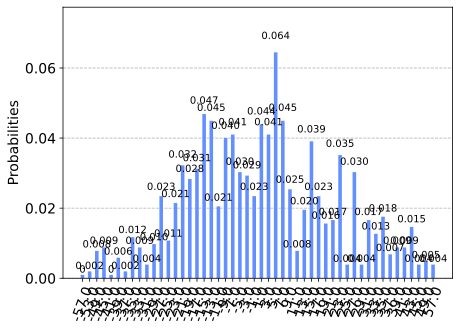

In [137]:
from scipy.optimize import minimize
#Minimize! COMPLETE CODE... 
p = 10
theta = np.random.randint(1, 10, 2 * p)
expectation = get_expectation(1, shots=1000)
res = minimize(expectation, theta, method='COBYLA')
print(res)

backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

qc_res = create_qaoa_circ(res.x, p)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

dic = {}

for x in counts: 
    obj = cost_function_C(x, G)
    if obj not in dic.keys(): 
        dic[obj]=counts[x]
    else: dic[obj]+=counts[x]

plot_histogram(dic)

<font color="blue" size="4">
    And we got a slightly better value of the cost function, namely, -4.27!
</font>

## Problem 2: 

As we learned in class, in adiabatic quantum computing, an easy-to-prepare ground state of a Hamiltonian $H_0$ is prepared, and then the Hamiltonian is gradually transformed into $H_1$, which is constructed in such a way that the groundstate of $H_1$ encodes the solution to the problem at hand. The transformation of $H_0$ to $H_1$ can for example be written on the form

$\displaystyle H(t) = \lambda(t) H_1 + (1 - \lambda(t)) H_0$

where $\lambda(t) = t/T$ is a function that goes from goes from $0$ to $1$ when $t$ goes from $0$ to $T$.

If this gradual tranformation is slow enough (satisfying the adiabicity critera), the evolution of the system will remain in its ground state. If the Hamiltonian is transformed from $H_0$ to $H_1$ too quickly, the system will get excited from the ground state, and the adiabatic computing algorithm fails. In this notebook we explore such dynamics.

The following cells were adapted by Emma Rosenfeld and Rodrigo Araiza Bravo from J. R. Johansson (robert@riken.jp), at [http://github.com/jrjohansson/qutip-lectures](http://github.com/jrjohansson/qutip-lectures).

In [81]:
from qutip import *
from scipy import *

### The following cell alocates some operators. No need to touch it. 

In [82]:
# pre-allocate operators
si = qeye(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()

sx_list = []
sy_list = []
sz_list = []

for i in range(n):
    op_list = []
    for m in range(n):
        op_list.append(si)

    op_list[i] = sx
    sx_list.append(tensor(op_list))

    op_list[i] = sy
    sy_list.append(tensor(op_list))

    op_list[i] = sz
    sz_list.append(tensor(op_list))

## Part c: Construct the Hamiltonian $H_0$, and Hamiltonian $H_1$, and initial state

#### Part c: code the Hamiltonians and initial ground state

We will use a Hamiltonian described by the equation above. You are to associate $H_\perp$ with $H_0$ or $H_1$ and $H_C$ with $H_0$ or $H_1$ in this section as well as code the initial state.

In [84]:
# ==========================================================
# Hamiltonian H_perp
# ==========================================================
H_perp = 0
b = 5
for i in range(n):
    H_perp += - b * sx_list[i]

# ==========================================================
# Hamiltonian H_C
# ==========================================================
H_C = 0
h = 2

for index in E:
    #Term that adds the ZZ term if x[index[0]], and x[index[1]]. 
    e1 = index[0]
    e2 = index[1]
    J = G[e1][e2]['weight']
    H_C += J * sz_list[e1] * sz_list[e2]

for i in range(n): 
    H_C += h* sz_list[i]

#COMPLETE THE CODE...
H0 = H_perp
H1 = H_C
#Completed!
# ==========================================================
# initial state
# ==========================================================

### COMPLETE THE CODE!
psi_0_single_qubit = (basis(2, 0) + basis(2, 1)).unit()

psi_list = [psi_0_single_qubit for i in range(n)]
psi0 = tensor(psi_list)
#Completed!

### Construct the full time-dependent Hamiltonian

#### Part (c)
Change maximum time T here after finding minimum gap

In [119]:
T = 0.1
t_list = np.linspace(0, T, 100)

args = {'T': max(t_list)}
h_t = [[H0, lambda t, args : (args['T']-t)/args['T']],
       [H1, lambda t, args : t/args['T']]]

### Evolve the system in time

The matrix *evals_mat* and *ekets_mat* contain M=20 eigenvalues and eigenvectors of the Hamiltonian, respectively, indexed by time, and the matrix *P_mat* contains the populations of the corresponding eigenstates indexed by time.

For example, *evals_mat[i]* returns an array of M eigenvalues at time t = i * T

In [120]:
M=20
# ==========================================================
# callback function for each time-step
# ==========================================================
evals_mat = np.zeros((len(t_list), M))
ekets_mat = []
P_mat = np.zeros((len(t_list), M))

idx = [0]
def process_rho(tau, psi):
  
    # evaluate the Hamiltonian with gradually switched on interaction 
    H = qobj_list_evaluate(h_t, tau, args)

    # find the M lowest eigenvalues of the system
    evals, ekets = H.eigenstates(eigvals=M)

    evals_mat[idx[0], :] = np.real(evals)
    ekets_mat.append(ekets)
    
    # find the overlap between the eigenstates and psi 
    for i, eket in enumerate(ekets):
        P_mat[idx[0],i] = abs((eket.dag().data * psi.data)[0,0])**2    
        
    idx[0] += 1

In [121]:
# Evolve the system, request the solver to call process_rho at each time step (no jump operators)
mesolve(h_t, psi0, t_list, [], process_rho, args)

Result object with sesolve data.
--------------------------------
expect = True
num_expect = 1, num_collapse = 0

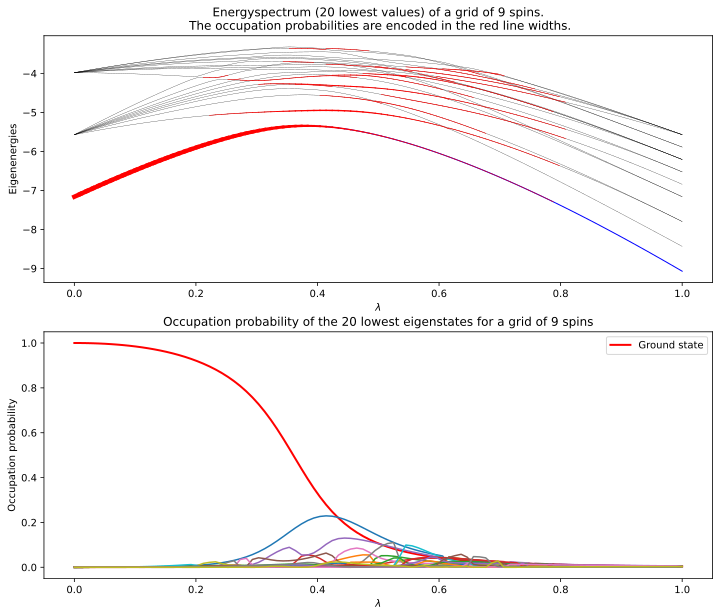

In [122]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ==========================================================
# plot the energy eigenvalues
# ==========================================================

# first draw thin lines outlining the energy spectrum
for i in range(len(evals_mat[0, :])):
    ls,lw = ('b',1) if i == 0 else ('k', 0.25)
    axes[0].plot(t_list/max(t_list), evals_mat[:, i] / (2*pi), ls, lw=lw)

# second, draw line that encode the occupation probability of each state in 
# its linewidth. thicker line => high occupation probability.
for idx in range(len(t_list)-1):
    for i in range(len(P_mat[0,:])):
        lw = 0.5 + 4*P_mat[idx,i]    
        if lw > 0.55:
           axes[0].plot(np.array([t_list[idx], t_list[idx+1]])/T, 
                        np.array([evals_mat[idx,i], evals_mat[idx+1,i]])/(2*pi), 
                        'r', linewidth=lw)    
        
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Eigenenergies')
axes[0].set_title("Energyspectrum (%d lowest values) of a grid of %d spins.\n " % (M,n)
                + "The occupation probabilities are encoded in the red line widths.")

#
# plot the occupation probabilities for the few lowest eigenstates
#
for i in range(len(P_mat[0,:])):
    if i == 0:
        axes[1].plot(t_list/max(t_list), 0 + P_mat[:,i], 'r', linewidth=2)
    else:
        axes[1].plot(t_list/max(t_list), 0 + P_mat[:,i])

axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylabel('Occupation probability')
axes[1].set_title("Occupation probability of the %d lowest " % M +
                  "eigenstates for a grid of %d spins" % n)
axes[1].legend(("Ground state",));
plt.show()

<font color="blue" size="4">
    Below we try a different value of $T$ that is larger, namely, $T = 10.$ We choose this because we want the evolution from $H_0$ to $H_1$ to happen as slowly as possible, which means we want $t / T$ to be small for a long period of time. This will ensure that the system stays (approximately) in the ground state as time advances.
</font>

## Part d:

Rerun the above algorithm with a different time T and obtain the probability that your final state ends up in the ground state as well as the value of the cost_function that the final state corresponds to. Compare your result to the QAOA problem, and explain any possible discrepancies.

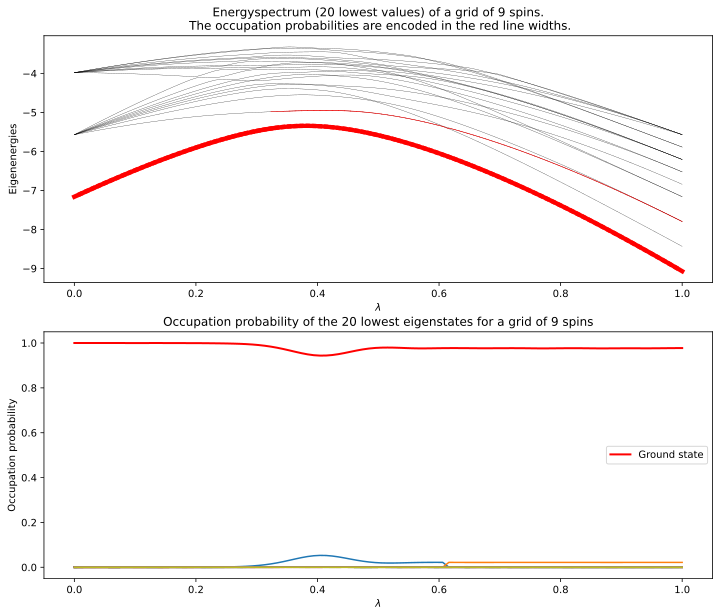

Minimum eigenvalue: -57.0
Probability of measuring the ground state: 0.9772473803413648


In [125]:
T = 10
t_list = np.linspace(0, T, 100)

args = {'T': max(t_list)}
h_t = [[H0, lambda t, args : (args['T']-t)/args['T']],
       [H1, lambda t, args : t/args['T']]]

M = 20
# ==========================================================
# callback function for each time-step
# ==========================================================
evals_mat = np.zeros((len(t_list), M))
ekets_mat = []
P_mat = np.zeros((len(t_list), M))

idx = [0]
def process_rho(tau, psi):
  
    # evaluate the Hamiltonian with gradually switched on interaction 
    H = qobj_list_evaluate(h_t, tau, args)

    # find the M lowest eigenvalues of the system
    evals, ekets = H.eigenstates(eigvals=M)

    evals_mat[idx[0], :] = np.real(evals)
    ekets_mat.append(ekets)
    
    # find the overlap between the eigenstates and psi 
    for i, eket in enumerate(ekets):
        P_mat[idx[0],i] = abs((eket.dag().data * psi.data)[0,0])**2    
        
    idx[0] += 1
    
# Evolve the system, request the solver to call process_rho at each time step (no jump operators)
mesolve(h_t, psi0, t_list, [], process_rho, args)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ==========================================================
# plot the energy eigenvalues
# ==========================================================

# first draw thin lines outlining the energy spectrum
for i in range(len(evals_mat[0, :])):
    ls,lw = ('b',1) if i == 0 else ('k', 0.25)
    axes[0].plot(t_list/max(t_list), evals_mat[:, i] / (2*pi), ls, lw=lw)

# second, draw line that encode the occupation probability of each state in 
# its linewidth. thicker line => high occupation probability.
for idx in range(len(t_list)-1):
    for i in range(len(P_mat[0,:])):
        lw = 0.5 + 4*P_mat[idx,i]    
        if lw > 0.55:
           axes[0].plot(np.array([t_list[idx], t_list[idx+1]])/T, 
                        np.array([evals_mat[idx,i], evals_mat[idx+1,i]])/(2*pi), 
                        'r', linewidth=lw)    
        
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel('Eigenenergies')
axes[0].set_title("Energyspectrum (%d lowest values) of a grid of %d spins.\n " % (M,n)
                + "The occupation probabilities are encoded in the red line widths.")

#
# plot the occupation probabilities for the few lowest eigenstates
#
for i in range(len(P_mat[0,:])):
    if i == 0:
        axes[1].plot(t_list/max(t_list), 0 + P_mat[:,i], 'r', linewidth=2)
    else:
        axes[1].plot(t_list/max(t_list), 0 + P_mat[:,i])

axes[1].set_xlabel(r'$\lambda$')
axes[1].set_ylabel('Occupation probability')
axes[1].set_title("Occupation probability of the %d lowest " % M +
                  "eigenstates for a grid of %d spins" % n)
axes[1].legend(("Ground state",));
plt.show()

print(f'Minimum eigenvalue: {evals_mat[-1, 0]}')
print(f'Probability of measuring the ground state: {P_mat[-1, 0]}')

<font color="blue" size="4">
    The adiabatic sweep end up giving the correct answer, namely the ground state of the $H_C$ Hamiltonian, and therefore minimizes the cost function. But the QAOA circuit above only gets to about -4, whereas the adiabatic sweep reaches -57, the actual minimum value. This is because the circuit is more difficult to optimize, whereas the adiabatic sweep allows the system to stay in the ground state via slow evolution. The potential tradeoff that results from this is that the adiabatic evolution is perhaps more difficult to implement experimentally, whereas circuits are less difficult, as evidenced by the many quantum devices we have today.
</font>